In [1]:
import soccertrack

from soccertrack import load_df
from soccertrack.logger import show_df, tqdm
from soccertrack import Camera

dataset_path = soccertrack.datasets.get_path("wide_view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

bbdf = soccertrack.load_df(path_to_csv)  # We will use this as ground truth
cam = Camera(path_to_mp4)  # Camera object will be used to load frames

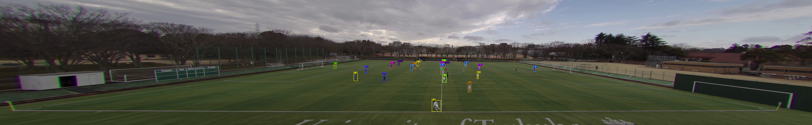

In [5]:
from soccertrack.utils import cv2pil

frame = cam.get_frame(0)
vis_frame = bbdf.visualize_frame(0, frame)

cv2pil(vis_frame, convert_bgr2rgb=False).resize((vis_frame.shape[1] // 8, vis_frame.shape[0] // 8))

In [18]:
from soccertrack.mot import TeamTracker
import numpy as np
from ast import literal_eval
import json 
from soccertrack.utils import get_git_root

def load_keypoints(keypoint_json):
    with open(keypoint_json, 'r') as f:
        data = json.load(f)

    source_keypoints = []
    target_keypoints = []

    for key,value in data.items():
        source_kp = value
        target_kp = literal_eval(key)
        source_keypoints.append(source_kp)
        target_keypoints.append(target_kp)

    source_keypoints = np.array(source_keypoints)
    target_keypoints = np.array(target_keypoints)
    return source_keypoints, target_keypoints

keypoint_json = get_git_root() / 'notebooks/02_user_guide/assets/soccer_keypoints.json'
cam = Camera(path_to_mp4)
cam.source_keypoints, cam.target_keypoints = load_keypoints(keypoint_json)

print(cam.H)

[[  -0.022512    -0.15867      143.47]
 [  0.0039563    -0.25595      113.53]
 [ 5.8605e-05  -0.0030103           1]]


In [7]:
long_df = bbdf.to_long_df()
long_df['x'] = long_df['bb_left'] + long_df['bb_width'] / 2
long_df['y'] = long_df['bb_top'] + long_df['bb_height'] / 2
long_df.head()

Attributes             bb_height  bb_left  bb_top  bb_width  conf         x  \
frame TeamID PlayerID                                                         
0     0      1             52.50  3543.00  607.00     30.00   1.0  3558.000   
             10            42.39  3536.42  555.93     13.57   1.0  3543.205   
             11            29.20  3560.51  506.69     10.60   1.0  3565.810   
             2             35.00  3830.00  524.00     11.00   1.0  3835.500   
             3             37.00  2671.00  512.00     20.00   1.0  2681.000   

Attributes                   y  
frame TeamID PlayerID           
0     0      1         633.250  
             10        577.125  
             11        521.290  
             2         541.500  
             3         530.500

In [8]:
import cv2

pts = long_df[["x", "y"]].values
pitch_pts = cv2.perspectiveTransform(np.asarray([pts], dtype=np.float32), cam.H)
long_df["pt_x"] = pitch_pts[0, :, 0]
long_df["pt_y"] = pitch_pts[0, :, 1]

long_df[['pt_x', 'pt_y']].head()

Attributes                  pt_x       pt_y
frame TeamID PlayerID                      
0     0      1         53.181614  49.415535
             10        52.616310  38.086201
             11        54.178875  16.078293
             2         71.051414  24.422363
             3          2.411253  26.487482

In [9]:
from soccertrack import CoordinatesDataFrame

arr = []
for frame_num, frame_df in long_df[['pt_x', 'pt_y']].iter_frames():
    frame_values = frame_df.values
    assert frame_values.shape == (23, 2), f"frame {frame_num} has shape {frame_values.shape}"
    
    arr.append(frame_values)
    
codf = CoordinatesDataFrame.from_numpy(np.array(arr))
codf.head()

TeamID              0                                                         \
PlayerID           0                     1                     2               
Attributes          x          y          x          y          x          y   
frame                                                                          
0           53.181614  49.415535  52.616310  38.086201  54.178875  16.078293   
1           53.179085  49.606544  52.604446  38.078987  54.172169  16.159447   
2           53.176079  49.833069  52.592594  38.073120  54.164764  16.240496   
3           53.173115  50.056713  52.580727  38.065903  54.157516  16.315622   
4           53.136147  50.132061  52.568619  38.058716  54.150860  16.396219   

TeamID                                                 ...          1  \
PlayerID           3                    4              ...         7    
Attributes          x          y         x          y  ...          x   
frame                                                  ...              
0           71.051414  24.422363  2.411253  26.487482  ...  38.489586   
1           71.051414  24.422363  2.411253  26.487482  ...  38.504295   
2           70.921646  24.215309  2.385502  26.490213  ...  38.518986   
3           70.854042  24.441044  2.359755  26.492947  ...  38.534702   
4           70.921646  24.215309  2.359755  26.492947  ...  38.549324   

TeamID                                                                        \
PlayerID                      8                     9                     10   
Attributes          y          x          y          x          y          x   
frame                                                                          
0           22.925461  37.975307  13.108757  26.944838  48.118477  22.484211   
1           22.975985  37.990318  13.132301  26.972507  48.160172  22.509399   
2           23.026453  38.004414  13.149574  26.999775  48.201797  22.534544   
3           23.081423  38.019146  13.169980  27.026989  48.243328  22.559669   
4           23.131695  38.033512  13.190381  27.054480  48.284752  22.585209   

TeamID                      ball             
PlayerID                      0              
Attributes          y          x          y  
frame                                        
0           36.014359  52.756401  30.603714  
1           36.045074  53.080727  30.561968  
2           36.075760  53.405094  30.523787  
3           36.106400  53.730705  30.481857  
4           36.136971  54.056320  30.443527  

[5 rows x 46 columns]

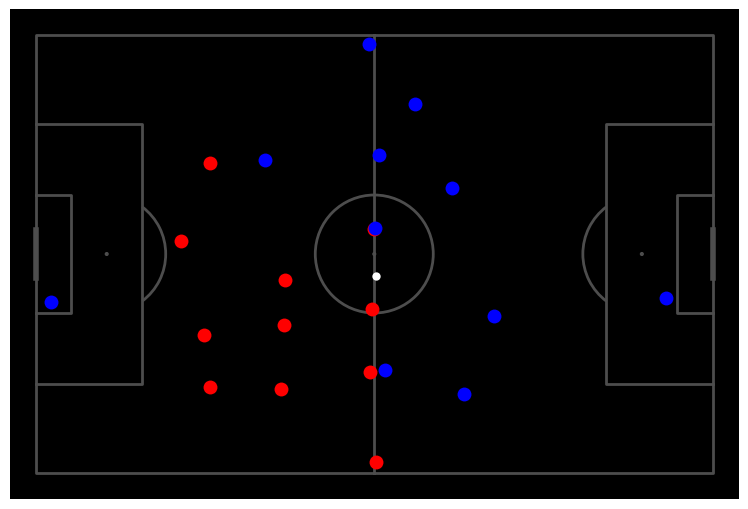

In [10]:
codf.visualize_frame(0)